<a href="https://colab.research.google.com/github/qqq3964/Konkuk_NLP_Practice/blob/main/week_3_201812822%EA%B9%80%ED%83%9C%EC%99%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>개인 구글 드라이브와 colab 연동</h1>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install konlpy

root_dir = "/content/drive/MyDrive/건국대NLP/4-2. Pretrained LM1"

import sys
sys.path.append(root_dir)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 106.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 30.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 KB 44.6 MB/s eta 0:00:00


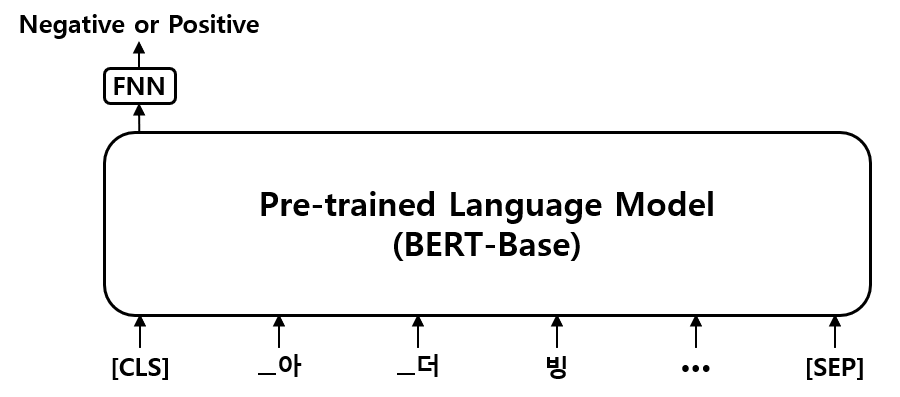

In [ ]:
import os
from IPython.display import Image
Image(os.path.join(root_dir, "BERT.png"))

<h1>BERT 모델을 이용한 감성분류</h1>

In [ ]:
import torch.nn as nn
from transformers import BertPreTrainedModel, BertModel


class SentimentClassifier(BertPreTrainedModel):

    def __init__(self, config):
        super(SentimentClassifier, self).__init__(config)

        # BERT 모델
        self.bert = BertModel(config)

        # 히든 사이즈
        self.hidden_size = config.hidden_size

        # 분류할 라벨의 개수
        self.num_labels = config.num_labels

        self.linear = nn.Linear(in_features=self.hidden_size, out_features=self.num_labels)

    def forward(self, input_ids):
        outputs = self.bert(input_ids=input_ids)
        # (batch_size, max_length, hidden_size)
        bert_output = outputs[0]

        # (batch_size, hidden_size)
        cls_vector = bert_output[:, 0, :] # bach_size, cls, hiddensize

        # class_output : (batch_size, num_labels)
        cls_output = self.linear(cls_vector)

        return cls_output

<h1>데이터 읽고 전처리 하기</h1>

<pre>
<b>1. read_data(file_path)</b>
  "train_datas_wordpiece.txt", "test_datas_wordpiece.txt" 파일을 읽기 위한 함수
  
  데이터 예시)
    ▁아 ▁더 빙 . . ▁진짜 ▁짜 증 나 네요 ▁목소리 \t negative
  
  read_file(file_path)
  args
    file_path : 읽고자 하는 데이터의 경로
  return
    datas : 영화 리뷰, 정답 라벨
    
    출력 예시)
      datas = [
        (['▁아', '▁더', '빙', '.', '.', '▁진짜', '▁짜', '증', '나', '네요', '▁목소리'], negative)

        (...),
        
        ]
      
<b>2. read_vocab_data(vocab_data_path)</b>
  "label_vocab.txt" 파일을 읽고 라벨을 indexing하기 위한 딕셔너리를 생성
   
  read_vocab_data(vocab_data_path)
  args
    vocab_data_path : 어휘 파일 경로
  return  
    term2idx : 라벨을 대응하는 index로 치환하기 위한 딕셔너리
    idx2term : index를 대응하는 라벨로 치환하기 위한 딕셔너리

<b>3. convert_data2feature(datas, max_length, tokenizer, label2idx)</b>
  입력 데이터를 고정된 길이로 변환 후 indexing
  Tensor로 변환
   
  convert_data2feature(datas, max_length, tokenizer, label2idx)
  args
    datas : 영화 리뷰 데이터와 대응하는 정답 라벨을 갖고 있는 리스트
    max_length : 입력의 최대 길이
    tokenizer : electra tokenizer 객체
    label2idx : 라벨을 대응하는 index로 치환하기 위한 딕셔너리
  return
    input_ids_features : 입력 문장에 대한 index sequence
    label_id_features : 정답을 갖고 있는 리스트
    
  전처리 예시)
    tokenizing된 리뷰 데이터['▁아', '▁더', '빙', '.', '.', '▁진짜', '▁짜', '증', '나', '네요', '▁목소리', ...]
    input_ids : [2, 3360, 28709, 18, 18, 12704, 29334, ... ]
    label_id : [1]
 </pre>


In [ ]:
import torch
from konlpy.tag import Okt
from konlpy.tag import Kkma

def read_data(file_path,kom):
    with open(file_path,'r',encoding='utf8') as Infile:
        # line 기준으로 나누어짐
        lines = Infile.readlines()

    datas = []
    for line in lines:
        # tap 기준으로 parsing
        pieces = line.strip().split("\t")
        # 리뷰와 정답
        input_sequence,label = pieces[0].split(" "),pieces[1]
        result = []
        for words in input_sequence:
            target_words = kom.pos(words)
            if len(target_words) == 2 and target_words[1][1] not in ['NNP','NP','JK','JKG','JKI','JKM','JKC','JKO','JKQ']:
                result.append(words)
            elif len(target_words) == 1 and target_words[0][1] not in ['NNP','NP','JK','JKG','JKI','JKM','JKC','JKO','JKQ']:
                result.append(words)
        datas.append((result,label))

    return datas


def read_vocab_data(vocab_data_path):
    term2idx, idx2term = {},{}

    with open(vocab_data_path, "r", encoding="utf8") as inFile:
        lines = inFile.readlines()

    for line in lines:
        term = line.strip()
        term2idx[term] = len(term2idx)
        idx2term[term2idx[term]] = term

    return term2idx, idx2term


def convert_data2feature(datas, max_length, tokenizer, label2idx):
    input_ids_features, label_id_features = [], []

    for input_sequence, label in datas:

        # CLS, SEP 토큰 추가
        tokens = [tokenizer.cls_token]
        tokens += input_sequence
        tokens = tokens[:max_length - 1]
        tokens += [tokenizer.sep_token]

        # word piece들을 대응하는 index로 치환
        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # padding 생성
        padding = [tokenizer._convert_token_to_id(tokenizer.pad_token)] * (max_length - len(input_ids))
        input_ids += padding

        label_id = label2idx[label]

        # 변환한 데이터를 각 리스트에 저장
        input_ids_features.append(input_ids)
        label_id_features.append(label_id)

    # 변환한 데이터를 Tensor 객체에 담아 반환
    input_ids_features = torch.tensor(input_ids_features, dtype=torch.long)
    label_id_features = torch.tensor(label_id_features, dtype=torch.long)

    return input_ids_features, label_id_features

<h1>BERT 모델 학습</h1>

<pre>
<b>1. read_data(file_path) 함수를 사용하여 학습 데이터 읽기</b>

<b>2. read_vocab_data(vocab_data_path) 함수를 사용하여 어휘 딕셔너리 생성</b>

<b>3. convert_data2feature(datas, max_length, tokenizer, label2idx) 함수를 사용하여 데이터 전처리</b>

<b>4. BERT 모델 객체 선언 후 사전 학습 파일 불러옴</b>

<b>5. epoch 마다 학습한 모델 파일 저장</b>
</pre>

In [ ]:
import torch
from torch.utils.data import (DataLoader, TensorDataset, RandomSampler)
import torch.optim as optim
import numpy as np

from transformers import BertConfig
from tokenization_kobert import KoBertTokenizer


def train(config):
    # BERT config 객체 생성
    bert_config = BertConfig.from_pretrained(pretrained_model_name_or_path=config["pretrained_model_name_or_path"],
                                             cache_dir=config["cache_dir_path"])
    setattr(bert_config, "num_labels", config["num_labels"])

    # BERT tokenizer 객체 생성
    bert_tokenizer = KoBertTokenizer.from_pretrained(pretrained_model_name_or_path=config["pretrained_model_name_or_path"],
                                                     cache_dir=config["cache_dir_path"])

    # 라벨 딕셔너리 생성
    label2idx, idx2label = read_vocab_data(vocab_data_path=config["label_vocab_data_path"])

    # 형태소 분석기
    kom = Kkma()

    # 학습 및 평가 데이터 읽기
    train_datas = read_data(file_path=config["train_data_path"],kom=kom)

    # 입력 데이터 전처리
    train_input_ids_features, train_label_id_features = convert_data2feature(datas=train_datas,
                                                                             max_length=config["max_length"],
                                                                             tokenizer=bert_tokenizer,
                                                                             label2idx=label2idx)

    # 학습 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    train_dataset = TensorDataset(train_input_ids_features, train_label_id_features)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=config["batch_size"],
                                  sampler=RandomSampler(train_dataset))

    # 사전 학습된 BERT 모델 파일로부터 가중치 불러옴
    model = SentimentClassifier.from_pretrained(pretrained_model_name_or_path=config["pretrained_model_name_or_path"],
                                                cache_dir=config["cache_dir_path"], config=bert_config).cuda()

    # loss를 계산하기 위한 함수
    loss_func = nn.CrossEntropyLoss()

    # 모델 학습을 위한 optimizer
    optimizer = optim.Adam(model.parameters(), lr=2e-5)

    for epoch in range(config["epoch"]):
        model.train()

        total_loss = []
        for batch in train_dataloader:
            batch = tuple(t.cuda() for t in batch)
            input_ids, label_id = batch

            # 역전파 단계를 실행하기 전에 변화도를 0으로 변경
            optimizer.zero_grad()

            # 모델 예측 결과
            hypothesis = model(input_ids)

            # loss 계산
            loss = loss_func(hypothesis, label_id)

            # loss 값으로부터 모델 내부 각 매개변수에 대하여 gradient 계산
            loss.backward()
            # 모델 내부 각 매개변수 가중치 갱신
            optimizer.step()

            # batch 단위 loss 값 저장
            total_loss.append(loss.data.item())

        bert_config.save_pretrained(save_directory=config["output_dir_path"])
        model.save_pretrained(save_directory=config["output_dir_path"])

        print("Average loss : {}".format(np.mean(total_loss)))

<h1>BERT 모델 평가</h1>

<pre>
<b>1. read_data(file_path) 함수를 사용하여 평가 데이터 읽기</b>

<b>2. read_vocab_data(vocab_data_path) 함수를 사용하여 어휘 딕셔너리 생성</b>

<b>3. convert_data2feature(datas, max_length, tokenizer, label2idx) 함수를 사용하여 데이터 전처리</b>

<b>4. BERT 모델 객체 선언 후 기존에 학습한 모델 파일 불러옴</b>

<b>5. 학습한 BERT 모델 평가</b>
</pre>

In [ ]:
import torch
from torch.utils.data import (DataLoader, TensorDataset, SequentialSampler)

from transformers import BertConfig
from tokenization_kobert import KoBertTokenizer
from sklearn.metrics import accuracy_score

def test(config):
    # BERT config 객체 생성
    bert_config = BertConfig.from_pretrained(pretrained_model_name_or_path=config["output_dir_path"],
                                             cache_dir=config["cache_dir_path"])

    # BERT tokenizer 객체 생성 (기존 BERT tokenizer 그대로 사용)
    bert_tokenizer = KoBertTokenizer.from_pretrained(pretrained_model_name_or_path=config["pretrained_model_name_or_path"],
                                                     cache_dir=config["cache_dir_path"])

    # 라벨 딕셔너리 생성
    label2idx, idx2label = read_vocab_data(vocab_data_path=config["label_vocab_data_path"])
    
    # 형태소 분석기
    kom = Kkma()

    # 평가 데이터 읽기
    test_datas = read_data(file_path=config["test_data_path"],kom=kom)
    test_datas = test_datas[:100]

    # 입력 데이터 전처리
    test_input_ids_features, test_label_id_features = convert_data2feature(datas=test_datas,
                                                                           max_length=config["max_length"],
                                                                           tokenizer=bert_tokenizer,
                                                                           label2idx=label2idx)

    # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    test_dataset = TensorDataset(test_input_ids_features, test_label_id_features)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=config["batch_size"],
                                 sampler=SequentialSampler(test_dataset))

    # 학습한 모델 파일로부터 가중치 불러옴
    model = SentimentClassifier.from_pretrained(pretrained_model_name_or_path=config["output_dir_path"],
                                                cache_dir=config["cache_dir_path"], config=bert_config).cuda()

    model.eval()
    total_hypothesis = []
    total_label_id = []
    pred = []
    target = []
    for batch in test_dataloader:
        batch = tuple(t.cuda() for t in batch)
        input_ids, label_id = batch

        with torch.no_grad():
            # 모델 예측 결과
            hypothesis = model(input_ids)
            # 모델의 출력값에 softmax와 argmax 함수를 적용
            hypothesis = torch.argmax(torch.softmax(hypothesis, dim=-1), dim=-1)

        # Tensor를 리스트로 변경
        hypothesis = hypothesis.cpu().detach().numpy().tolist()
        label_id = label_id.cpu().detach().numpy().tolist()

        for index in range(len(input_ids)):
            input_tokens = bert_tokenizer.convert_ids_to_tokens(input_ids[index])
            input_sequence = bert_tokenizer.convert_tokens_to_string(input_tokens[1:input_tokens.index(bert_tokenizer.sep_token)])
            predict = idx2label[hypothesis[index]]
            correct = idx2label[label_id[index]]

            # 정답과 예측값 추가
            pred.append(int(label2idx[predict]))
            target.append(int(label2idx[correct]))
    print(f'accuracy : {accuracy_score(y_pred=pred,y_true=target)}')


### 성능 평가

저는 형태소 분석기를통해 고유명사와 조사들을 제거하였습니다. </br>
형태소 분석기로는 Kkma를 이용해서 전처리 해주었습니다.</br>
- 원래 모델 accuracy = 80프로</br>
- 저의 모델 accuracy = 84프로

In [ ]:
import os


if(__name__=="__main__"):
    output_dir = os.path.join(root_dir, "output")
    cache_dir = os.path.join(root_dir, "cache")
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)


    config = {"mode": "test",
              "train_data_path": os.path.join(root_dir, "train_datas_wordpiece.txt"),
              "test_data_path": os.path.join(root_dir, "test_datas_wordpiece.txt"),
              "output_dir_path":output_dir,
              "cache_dir_path": cache_dir,
              "pretrained_model_name_or_path": "monologg/kobert",
              "label_vocab_data_path": os.path.join(root_dir, "label_vocab.txt"),
              "num_labels": 2,
              "max_length": 142,
              "epoch":10,
              "batch_size":64
              }

    if(config["mode"] == "train"):
        train(config)
    else:
        test(config)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


accuracy : 0.84
